<a href="https://colab.research.google.com/github/SlopeStriker/Python_Training/blob/Israelsen_Python_Fundamentals/Python_Fundamentals_Customer_Churn_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer Churn

"Customer churn" is a term used to describe when a company loses customers.  The example in this notebook involves a scenario familiar to many: switching mobile phone providers.  If my provider could identify my intent to switch early, it could entice me to stay with timely offers, such as a phone upgrade or a new service feature.

Machine learning can help us identify patterns in the data for customers who left in the past, thus helping us prevent the same churn in the future.

The data for this notebook is included in `churn.csv`.

# 1. Setup

Import the necessary libraries.  NOTE: If you're using an environment other than Google Colab, you may need to first install some of these using `!pip`.
*   **pandas**: A library for organizing and manipulating data, making it easy to work with tables.
*   **numpy**: A library for numerical computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
*   **matplotlib**: A plotting library for Python, used to create static, animated, and interactive graphs and charts.
*   **seaborn**: A statistical data visualization library built on top of matplotlib, offering a higher-level interface for drawing statistical graphics.
*   **xgboost**: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable, used for building machine learning models, especially for solving data science challenges involving structured data.





In [17]:
# If you need to install libraries, you can do so using this syntax
# !pip install xgboost

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 2. Data Cleansing and Exploratory Data Analysis

It all starts with data.  Load the data from churn.csv into a DataFrame, then explore and visualize it to help us better understand what we're working with, and what will be most important to pass to the model when we train it.

In [19]:
# LOAD THE DATA

# We'll use pandas to load the CSV data into a DataFrame
# If using Google Colab, the file should be uploaded to /content folder
churn = pd.read_csv('churn.csv')

# Display the first five rows of the dataset to understand its structure
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [20]:
# CLEAN THE DATA

# Check for missing values
# If there are any missing values, you can fill them with a placeholder or drop them, depending on the context
# We don't actually have missing values in this dataset, we'll just print
print(churn.isnull().sum())

# Standardize data for boolean columns, making everything "True" or "False"
churn["Churn?"] = churn["Churn?"].map({'False.': False, 'True.': True})
churn["Int'l Plan"] = churn["Int'l Plan"].map({'no': False, 'yes': True})
churn["VMail Plan"] = churn["VMail Plan"].map({'no': False, 'yes': True})

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64


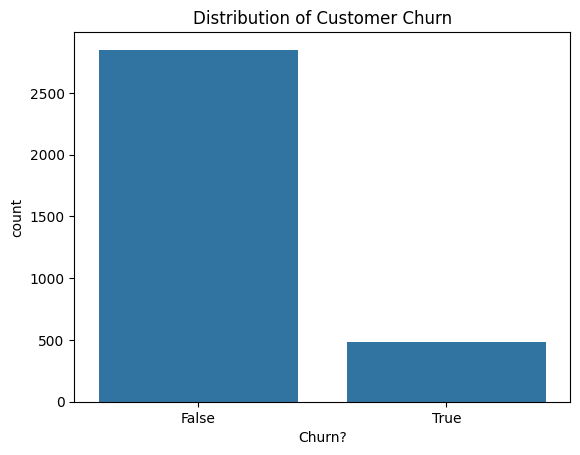

Percentage of customers who churned: 14.49%


In [21]:
# EXPLORE AND VISUALIZE THE DATA

# Visualize the distribution of customer churn
sns.countplot(x='Churn?', data=churn)
plt.title('Distribution of Customer Churn')
plt.show()

# Calculate the percentage of churn
churn_percentage = churn['Churn?'].value_counts(normalize=True) * 100
# Print the percentage of customers who churned
print(f"Percentage of customers who churned: {churn_percentage[1]:.2f}%")

There is some imbalance in the data, as only 14.49% of customers churned, but this is not extreme imbalance.

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


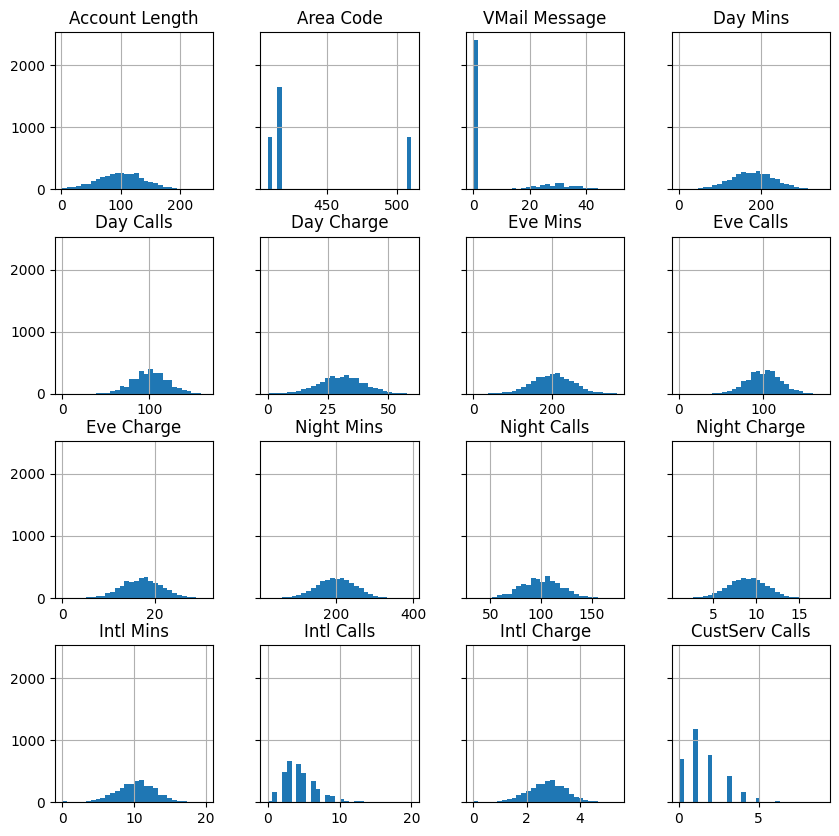

In [22]:
# Histograms for each numeric features, to see how balanced the data is
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

Most numeric features are well-distributed, showing a bell-shaped (or Gaussian) distribution.  In machine learning, this normality is desired for optimal perforamnce of the algorithms.  The exceptions are `VMail Message` and `Area Code`, which we'll handle below.

In [23]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object', 'bool']).columns:
    # Using 'display' to show the DataFrame and 'pd.crosstab()' to create the frequency table
    display(column, pd.crosstab(index=churn[column], columns='% observations', normalize='columns') * 100)  # Multiplying by 100 to convert to percentage

'State'

col_0,% observations
State,
AK,1.560156
AL,2.400240
AR,1.650165
AZ,1.920192
CA,1.020102
CO,1.980198
CT,2.220222
DC,1.620162
DE,1.830183


'Phone'

col_0,% observations
Phone,
327-1058,0.030003
327-1319,0.030003
327-3053,0.030003
327-3587,0.030003
327-3850,0.030003
...,...
422-7728,0.030003
422-8268,0.030003
422-8333,0.030003


"Int'l Plan"

col_0,% observations
Int'l Plan,
False,90.309031
True,9.690969


'VMail Plan'

col_0,% observations
VMail Plan,
False,72.337234
True,27.662766


'Churn?'

col_0,% observations
Churn?,
False,85.508551
True,14.491449


This exploration tells us:
*   `State`: Fairly well distributed; we will check correlations later
*   `Phone`: With all the unique values, it will be hard to use this as a feature.  We should drop this, along with `Area Code`, as it goes with `Phone`.
*   `Int'l Plan`: We will  check correlations later
*   `VMail Plan`: We will check correlations later
*   `Churn`: The target feature; included here because it's a categorical feature (meaning it can take on just a fixed number of possible values)

In [24]:
# Drop Area Code and Phone from the dataset
churn = churn.drop(['Phone', 'Area Code'], axis=1)

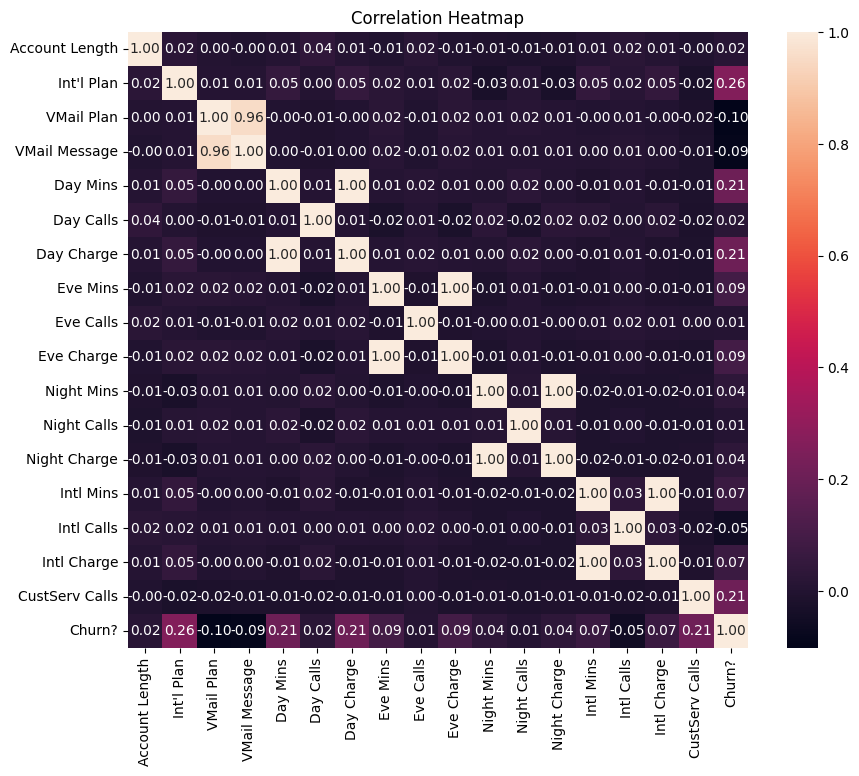

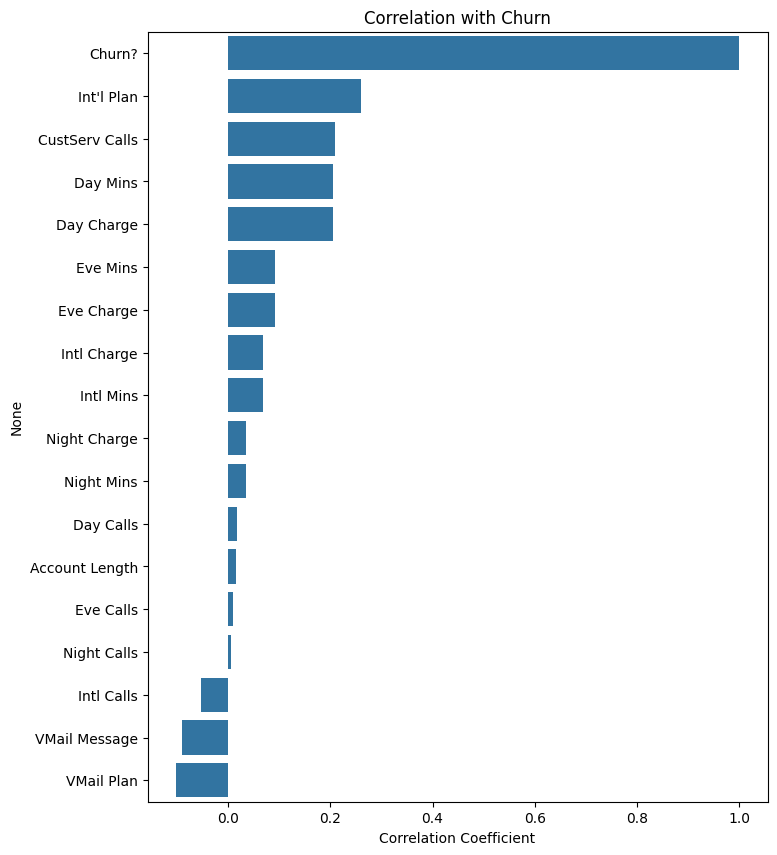

Churn?            1.000000
Int'l Plan        0.259852
CustServ Calls    0.208750
Day Mins          0.205151
Day Charge        0.205151
Eve Mins          0.092796
Eve Charge        0.092786
Intl Charge       0.068259
Intl Mins         0.068239
Night Charge      0.035496
Night Mins        0.035493
Day Calls         0.018459
Account Length    0.016541
Eve Calls         0.009233
Night Calls       0.006141
Intl Calls       -0.052844
VMail Message    -0.089728
VMail Plan       -0.102148
Name: Churn?, dtype: float64

In [25]:
# Two options to help visualize the correlation between features and Churn (heatmap and correlation matrix)
# Dropping column 'State' in DataFrame to ensure that heatmap function is working.
relevant_columns = churn
relevant_columns = relevant_columns.drop(["State"], axis=1)
correlation_matrix = relevant_columns.corr()

# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Calculate the correlation matrix, focusing on the Churn column
churn_correlations = correlation_matrix["Churn?"].sort_values(ascending=False)

# Plotting the correlations with Churn
plt.figure(figsize=(8, 10))
sns.barplot(x=churn_correlations.values, y=churn_correlations.index)
plt.title("Correlation with Churn")
plt.xlabel("Correlation Coefficient")
plt.show()

churn_correlations

This exploration tells us:

*   `Int'l Plan`: There's a positive correlation (0.26) between having an international plan and churn, suggesting customers with international plans are more likely to churn. This could be due to various factors such as cost, satisfaction with international service, or other reasons that warrant further investigation.

*   `CustServ Calls`: The number of customer service calls is positively correlated (0.21) with churn, indicating that customers who contact customer service more frequently are more likely to leave. This might reflect issues with service satisfaction or unresolved problems.

*   `Day Mins` and `Day Charge`: Both of these features show a positive correlation (about 0.21) with churn, suggesting that higher day time usage (and the associated charges) could be a factor in customers' decision to churn.

*   `VMail Plan` and `VMail Message`: These features are negatively correlated with churn (-0.10 and -0.09, respectively), indicating that customers who use voicemail services are less likely to churn. This could be interpreted as an indicator of customer engagement or satisfaction with the service.

*   `Intl Calls`: Interestingly, the number of international calls is negatively correlated (-0.05) with churn, which might suggest that customers making more international calls are less likely to leave, contrasting with the positive correlation seen with having an international plan.


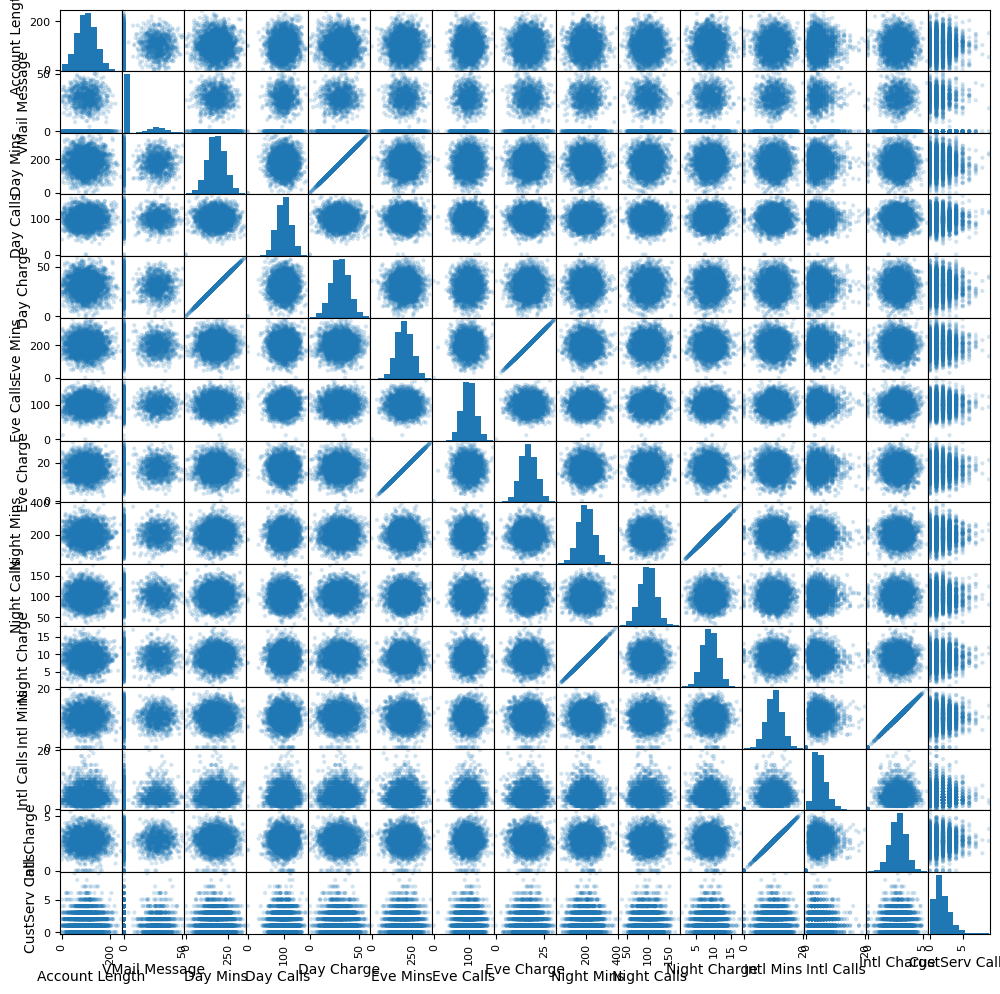

In [26]:
# Scatter matrix to visualize the relationship between non-target (i.e., "Churn") features
pd.plotting.scatter_matrix(churn.select_dtypes(include=[np.number]), figsize=(12, 12), alpha=0.2)
plt.show()

This exploration tells us:


*   Some features (the ones with a diagonal line on the scatter matrix) have a correlation of 100% with one another (such as Day Charge and Day Mins, Night Charge and Night Mins)
*   Features like this can cause problems when we train the model later, so we'll remove the "Charge" features

In [27]:
# Drop features for Day Charge, Eve Charge, Night Charge, Intl Charge to remove the 100% correlation issue
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [28]:
# One-hot encode the State column so we have 0s and 1s rather than string data
churn_encoded = pd.get_dummies(churn, columns=['State'])

# 3. Building and Training the Model

In this section, we split the data into training, validation and test sets.  Then we build the model, inputting various parameters.  Finally, we train the model on the training dataset, evaluting it with the validation dataset.

In [29]:
# Split the data into training, validation and test sets

# Randomly shuffle the dataset and split it into training (70%), validation (20%), and testing (10%) sets
train_data, validation_data, test_data = np.split(churn_encoded.sample(frac=1, random_state=1729),
                                                  [int(0.7 * len(churn)), int(0.9 * len(churn))])

In [30]:
# Assuming the last column "Churn?" is the target variable
# Separate the features and the target variable for each dataset
X_train = train_data.drop("Churn?", axis=1)
y_train = train_data["Churn?"]
X_val = validation_data.drop("Churn?", axis=1)
y_val = validation_data["Churn?"]
X_test = test_data.drop("Churn?", axis=1)
y_test = test_data["Churn?"]

# Convert the datasets into DMatrix format for XGBoost
# XGBoost works well with DMatrix, a data structure optimized for both memory efficiency and training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [31]:
# Specify parameters for the model
params = {
    'max_depth': 3,  # The maximum depth of the decision tree; can be adjusted (typically ranges 3-10)
    'eta': 0.1,  # The learning rate (how much the model adjusts itself in response to errors); can be adjusted
    'objective': 'binary:logistic',  # We're choosing this because it's a binary problem (customers either churn or they don't)
                                     # Logistic means it will output a probability (the probability that a customer will leave)
    'eval_metric': 'auc',  # Evaluation metrics for validation data, e.g., "auc" or "Area Under the Curve" for binary classification
}
num_rounds = 100  # The number of rounds for boosting


In [32]:
# Train the model using the training dataset and evaluate it using the validation dataset
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_rounds, evallist)

[0]	eval-auc:0.79041	train-auc:0.84783
[1]	eval-auc:0.79017	train-auc:0.84931
[2]	eval-auc:0.79017	train-auc:0.84932
[3]	eval-auc:0.81304	train-auc:0.87279
[4]	eval-auc:0.84338	train-auc:0.90166
[5]	eval-auc:0.84644	train-auc:0.90539


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[6]	eval-auc:0.84819	train-auc:0.90678
[7]	eval-auc:0.84730	train-auc:0.90643
[8]	eval-auc:0.85320	train-auc:0.90922
[9]	eval-auc:0.85490	train-auc:0.91089
[10]	eval-auc:0.85651	train-auc:0.91213
[11]	eval-auc:0.85710	train-auc:0.91321
[12]	eval-auc:0.85804	train-auc:0.91365
[13]	eval-auc:0.85405	train-auc:0.92678
[14]	eval-auc:0.86634	train-auc:0.92544
[15]	eval-auc:0.86711	train-auc:0.92673
[16]	eval-auc:0.86819	train-auc:0.92803
[17]	eval-auc:0.86900	train-auc:0.92859
[18]	eval-auc:0.86859	train-auc:0.92815
[19]	eval-auc:0.86826	train-auc:0.92838
[20]	eval-auc:0.87059	train-auc:0.93021
[21]	eval-auc:0.87109	train-auc:0.93048
[22]	eval-auc:0.87180	train-auc:0.93095
[23]	eval-auc:0.87204	train-auc:0.93109
[24]	eval-auc:0.87312	train-auc:0.93209
[25]	eval-auc:0.87283	train-auc:0.93228
[26]	eval-auc:0.87435	train-auc:0.93292
[27]	eval-auc:0.87420	train-auc:0.93313
[28]	eval-auc:0.87343	train-auc:0.93313
[29]	eval-auc:0.87277	train-auc:0.93500
[30]	eval-auc:0.87292	train-auc:0.93505
[31]

AUC values range from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
AUC values between 0.5 and 1.0 indicate useful models. A value of 0.5 suggests a model that does no better than random chance.

Higher AUC values indicate better model performance. In our model, the AUC for both the evaluation set (eval-auc) and the training set (train-auc) increases over the iterations, suggesting the  model is learning and improving its ability to distinguish between the classes over time.


# 4. Evaluating the Model



Initially, the gap between training and evaluation AUC is somewhat moderate, but it starts to widen significantly as training progresses. For instance, towards the end (around iteration 99), the train-auc is at 0.97169 while the eval-auc is at 0.87690. This growing gap may suggest that the model is beginning to overfit the training data-—meaning it's getting better at predicting the training data, but not the evaluation data.  This suggests that the model is fitting more to the idiosyncrasies of the training data rather than capturing generalizable patterns that apply to unseen data.

**Actions to Consider**:

**Early Stopping**: Implement early stopping to halt the training process once the evaluation metric stops improving for a specified number of rounds. XGBoost supports early stopping.

**Regularization**: Increase regularization parameters (lambda, alpha) to penalize more complex models and thus mitigate overfitting.

**Parameter Tuning**: Adjust other hyperparameters, like max_depth, min_child_weight, and subsample, to help control model complexity and fit.

**Cross-Validation**: Use XGBoost's built-in cross-validation method to assess model performance more robustly. This might give you a better indication of how the model will perform on unseen data.

**Feature Engineering**: Revisit your features to ensure they're relevant and not leading to overfitting. Removing irrelevant or highly correlated features can sometimes improve model generalizability.

In [33]:
# Implementing early stopping (i.e., train the model to learn from data until it stops getting better)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Set to a high number intentionally; training may stop much earlier
    evals=[(dval, "eval")],
    early_stopping_rounds=10  # Stops after 10 rounds of no improvement on the eval dataset
)

# After training, you can access the best iteration
# This is the number of the training round where the model performed the best on the validation dataset before it stopped improving
# We'll use this in the next code block
print(f"Best iteration: {bst.best_iteration}")


[0]	eval-auc:0.79041
[1]	eval-auc:0.79017
[2]	eval-auc:0.79017
[3]	eval-auc:0.81304
[4]	eval-auc:0.84338
[5]	eval-auc:0.84644
[6]	eval-auc:0.84819
[7]	eval-auc:0.84730
[8]	eval-auc:0.85320
[9]	eval-auc:0.85490
[10]	eval-auc:0.85651
[11]	eval-auc:0.85710
[12]	eval-auc:0.85804
[13]	eval-auc:0.85405
[14]	eval-auc:0.86634
[15]	eval-auc:0.86711
[16]	eval-auc:0.86819
[17]	eval-auc:0.86900
[18]	eval-auc:0.86859
[19]	eval-auc:0.86826
[20]	eval-auc:0.87059
[21]	eval-auc:0.87109
[22]	eval-auc:0.87180
[23]	eval-auc:0.87204
[24]	eval-auc:0.87312
[25]	eval-auc:0.87283
[26]	eval-auc:0.87435
[27]	eval-auc:0.87420
[28]	eval-auc:0.87343
[29]	eval-auc:0.87277
[30]	eval-auc:0.87292
[31]	eval-auc:0.87313
[32]	eval-auc:0.87377
[33]	eval-auc:0.87377
[34]	eval-auc:0.87470
[35]	eval-auc:0.87435
[36]	eval-auc:0.87470
[37]	eval-auc:0.87439
[38]	eval-auc:0.87484
[39]	eval-auc:0.87820
[40]	eval-auc:0.87955
[41]	eval-auc:0.88028
[42]	eval-auc:0.87992
[43]	eval-auc:0.88043
[44]	eval-auc:0.87994
[45]	eval-auc:0.8813

In [34]:
# Make predictions with the test dataset on the final (best) model

# Predicting the probabilities for the positive class ("Churn")
y_pred_proba = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

# The scikit-learn library is great for calculating AUC and other metrics, though this could also be calculated manually
from sklearn.metrics import roc_auc_score

# Print the final AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Final AUC on Test Dataset: {auc_score:.3f}")

Final AUC on Test Dataset: 0.906


An AUC score of over 0.9 is often considered excellent in many applications. It indicates strong differentiation between the positive and negative classes in the dataset, suggesting that the model has a good predictive ability for the task at hand.